# Importing Libraries:
Main libraries include pandas, numpy, matplotlib, and datetime

In [1]:
# !pip install certifi

In [2]:
# !pip install statsmodels --upgrade

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from google.colab import files

# Importing Excels:

The source for Excels is from https://www.gso.gov.vn/xuat-nhap-khau/. This is a website owned by the General Statistics Office, an agency under the Ministry of Planning and Investment. It manages and reports Vietnam's economic and social statistics.

The imported Excels summarize Vietnam's monthly exports by product categories from 2015 to 2022.


In [4]:
!wget https://www.gso.gov.vn/wp-content/uploads/2022/03/V01-2022-9.xls  --no-check-certificate -O 22.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2021/03/V01-2021-10.xls --no-check-certificate -O 21.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2020/10/V01-2020-4.xls  --no-check-certificate -O 20.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2019-2.xls   --no-check-certificate -O 19.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2018.xls     --no-check-certificate -O 18.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2017.xls     --no-check-certificate -O 17.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1-2016.xls     --no-check-certificate -O 16.xls
!wget https://www.gso.gov.vn/wp-content/uploads/2019/11/V1_2015.xls.    --no-check-certificate -O 15.xls

--2023-06-28 21:41:14--  https://www.gso.gov.vn/wp-content/uploads/2022/03/V01-2022-9.xls
Resolving www.gso.gov.vn (www.gso.gov.vn)... 210.245.31.100
Connecting to www.gso.gov.vn (www.gso.gov.vn)|210.245.31.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 190464 (186K) [application/vnd.ms-excel]
Saving to: ‘22.xls’

22.xls              100%[===================>] 186.00K  --.-KB/s    in 0.09s   

2023-06-28 21:41:14 (1.96 MB/s) - ‘22.xls’ saved [190464/190464]

--2023-06-28 21:41:14--  https://www.gso.gov.vn/wp-content/uploads/2021/03/V01-2021-10.xls
Resolving www.gso.gov.vn (www.gso.gov.vn)... 210.245.31.100
Connecting to www.gso.gov.vn (www.gso.gov.vn)|210.245.31.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 190976 (186K) [application/vnd.ms-excel]
Saving to: ‘21.xls’

21.xls              100%[===================>] 186.50K  

# Data Pre-processing:

There are eight Excels, each of which is a dataframe. All dataframes are put into a dictionary called "dfs" for concatenation later.

Each df can be accessed using "df_name" as a variable. They have to be processed so that redundant columns and rows are eliminated. In the end, there will be 13 columns (including index) and six rows (five chosen categories and the timeline)

In [5]:
# Create a list of year names that match the uploaded database
list_of_years = [f'{i}.xls' for i in range (15,23)]
dfs = {}

# Enumerate will create a tuple
for i, each_year in enumerate(list_of_years):
    # Create dataframe name that matches each Excel year
    df_name = f"df{each_year[:-4]}"
    # Use dfs[df_name] to refer to each df from this point
    dfs[df_name] = pd.read_excel(each_year)
    # Extract year to rename columns later
    year = re.search(r'\d+', each_year).group()


    ### Pre-Processing df of one year ###

    # Delete redundant rows and columns
    x='ĐVT'
    if dfs[df_name]['Unnamed: 1'].str.contains(x).any():
        dfs[df_name] = dfs[df_name].drop('Unnamed: 1',axis=1)

    dfs[df_name]= dfs[df_name].iloc[:, ::2]
    dfs[df_name]= dfs[df_name].iloc[:,:13]

    dfs[df_name].rename(columns=dfs[df_name].iloc[1],inplace=True)
    dfs[df_name] = dfs[df_name].dropna(subset=['Tên hàng'])
    dfs[df_name]=dfs[df_name].iloc[1:]

    # Index and rename columns with format MM/YY
    dfs[df_name]=dfs[df_name].set_index('Tên hàng', inplace=False)
    columns_name = [f'{month}/{year}' for month in range(1,13)]
    dfs[df_name].columns = columns_name

    # Filter to five cateogories with highest potential growth
    dfs[df_name] = dfs[df_name].loc[dfs[df_name].index.str.contains('hải|sản phẩm gỗ|dệt may|sắt|vi tính')]

dfs['df22']
# dfs

,1/22,2/22,3/22,4/22,5/22,6/22,7/22,8/22,9/22,10/22,11/22,12/22
Tên hàng,,,,,,,,,,,,
Hàng hải sản,872493.336,635366.207,1015927.918,1126138.725,1056067.376,999007.81,936417.054,991971.4,855212.623,897202.552,784440.765,753191.124
Gỗ và sản phẩm gỗ,1549310.749,890952.098,1538602.971,1616203.012,1394158.535,1407014.678,1320480.119,1440135.173,1118225.738,1211470.349,1200663.812,1323930.505
Hàng dệt may,3571336.194,2065292.683,3041730.052,3153379.948,3168068.204,3530808.064,3709007.293,4045062.989,2729365.914,2715943.605,2915583.825,2921066.766
Sản phẩm từ sắt thép,424127.327,294632.437,447854.67,439608.593,411356.334,401854.174,388521.572,428843.382,359794.291,328824.032,361962.096,363800.484
"Máy vi tính, sản phẩm điện tử & linh liện",4109864.137,3844660.029,5285704.388,4467755.676,4805859.038,5167119.202,4040649.656,4988923.072,5134612.548,4777099.349,4119441.26,4794748.807


# Data Consolidation:

Data is renamed into English and collapsed from months to quarters. In total, there are 32 quarters from Q1 2015 to Q4 2022

In [6]:
# Concatenate all dataframes into one
df_all = pd.concat(dfs.values(), axis=1)

# Transpose and translate columns to English
df_all = df_all.T
df_all = df_all.rename(columns={'Hàng hải sản':'Seafoods',
                                'Gỗ và sản phẩm gỗ':'Wood & Products from Wood',
                                'Hàng dệt may':'Textile',
                                'Sản phẩm từ sắt thép':'Steel & Products from Steel',
                                'Máy vi tính, sản phẩm điện tử & linh liện':'Electronics'})



# Group months into quarters and change format to MM/YYYY
df_all.index = pd.to_datetime(df_all.index, format='%m/%y')

df_quarter = df_all.resample('Q').sum()

df_quarter.index = df_quarter.index.strftime('%m/%Y')


print(df_quarter)

'''
# Download the Excel file to the local machine
df_quarter.to_excel('my_data.xlsx', index=True)
files.download('my_data.xlsx')
# '''


Tên hàng     Seafoods  Wood & Products from Wood       Textile  \
03/2015   1366399.628                1530759.749  4.887089e+06   
06/2015   1670496.830                1668160.919  5.469779e+06   
09/2015   1819308.650                1744995.740  6.823056e+06   
12/2015   1867828.307                1987255.943  5.895207e+06   
03/2016   1408853.597                1519223.934  5.125443e+06   
06/2016   1675185.572                1695375.329  5.721721e+06   
09/2016   1931436.927                1765321.535  6.938714e+06   
12/2016   2037649.463                1989175.522  6.055482e+06   
03/2017   1511225.550                1780029.487  5.623523e+06   
06/2017   2075967.607                1876699.029  6.125398e+06   
09/2017   2405554.050                1887244.818  7.465490e+06   
12/2017   2322987.461                2114755.648  6.824036e+06   
03/2018   1767850.247                1937268.242  6.425318e+06   
06/2018   2199704.089                2187191.173  7.216627e+06   
09/2018   

"\n# Download the Excel file to the local machine\ndf_quarter.to_excel('my_data.xlsx', index=True)\nfiles.download('my_data.xlsx')\n# "

#Date Exploratory:
Visualize the trends of five categories by plotting the numbers in the line graph



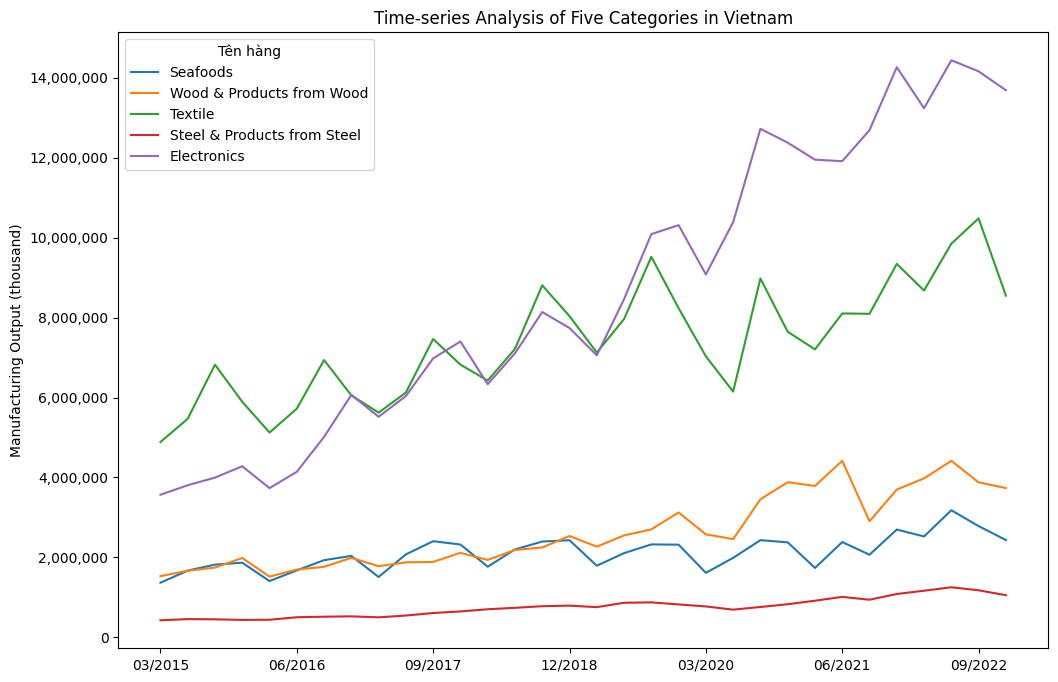

In [7]:
ax = df_quarter.plot(figsize=(12, 8), grid=0)

# Set y-axis tick label format to reveal all numbers
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Set y axis and title labels
ax.set_ylabel('Manufacturing Output (thousand)')
plt.title('Time-series Analysis of Five Categories in Vietnam')

# Show the plot
plt.show()
plt.close()

#Picking the category:
From our observation above, electronics can be seen to have the greatest growth
potential so we will choose it for further forecasting


In [8]:
df_etron = df_quarter['Electronics']

# Check the info, make sure quarters are datetime and indexed
df_etron.info()


<class 'pandas.core.series.Series'>
Index: 32 entries, 03/2015 to 12/2022
Series name: Electronics
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 512.0+ bytes


We can then visualize the trend with only Electronics data

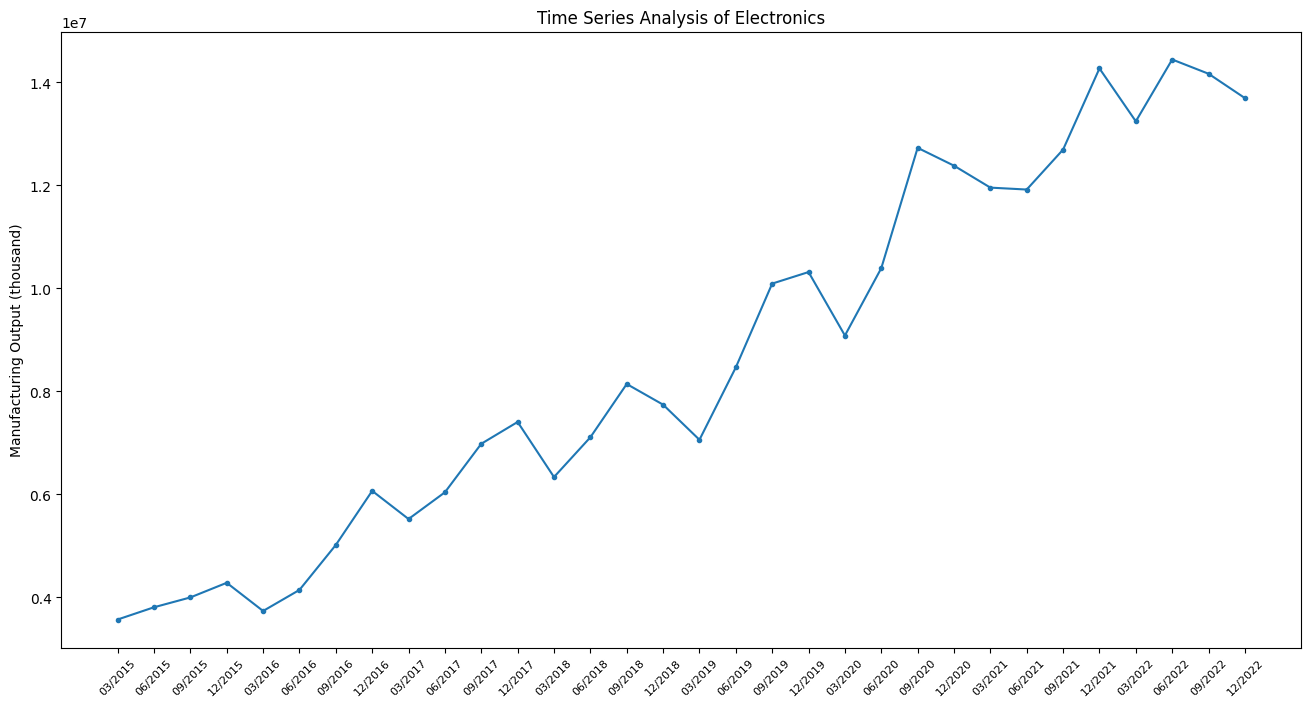

In [9]:
# Visualize the trend
plt.figure(figsize=(16,8))
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('Manufacturing Output (thousand)',fontsize=10)
plt.title('Time Series Analysis of Electronics')

plt.plot(df_etron, marker='.')


*Note that 1e7 is equivalent to 10,000,000

#Splitting the dataset:
The ratio of data used for train vs. test is around 80/20, or that 26 months for training and 6 months for testing data

In [10]:
# Splitting the data into train and test
df_train, df_test = df_etron.iloc[:-6], df_etron.iloc[-6:]
print(df_train)
print(df_test)

03/2015    3.568708e+06
06/2015    3.806313e+06
09/2015    3.997303e+06
12/2015    4.281364e+06
03/2016    3.734117e+06
06/2016    4.143020e+06
09/2016    5.016001e+06
12/2016    6.065973e+06
03/2017    5.519562e+06
06/2017    6.038466e+06
09/2017    6.980333e+06
12/2017    7.403732e+06
03/2018    6.334405e+06
06/2018    7.106280e+06
09/2018    8.140554e+06
12/2018    7.739629e+06
03/2019    7.057903e+06
06/2019    8.463563e+06
09/2019    1.008999e+07
12/2019    1.031411e+07
03/2020    9.081868e+06
06/2020    1.038940e+07
09/2020    1.272592e+07
12/2020    1.237920e+07
03/2021    1.195330e+07
06/2021    1.191610e+07
Name: Electronics, dtype: float64
09/2021    1.269216e+07
12/2021    1.426732e+07
03/2022    1.324023e+07
06/2022    1.444073e+07
09/2022    1.416419e+07
12/2022    1.369129e+07
Name: Electronics, dtype: float64


#Stationarity Testing:
Test whether the dataset is stationary or not. This step is important for time-series analysis to make forecasting and modeling more accurate

In [11]:
result = adfuller(df_train)
print(result[1])

0.9990255302070049


The null hypothesis for the adfuller test is that the dataset is non-stationary. Since the result returns that the **p-value** is **0.99**, which is higher than 0.05 (significance level), we fail to reject the null hypothesis. In other words, the series is non-stationary. This makes sense because the series shows an upward trend in the graph above.

#Changing the series to stationary:
Use log and diff to make the dataset stationary


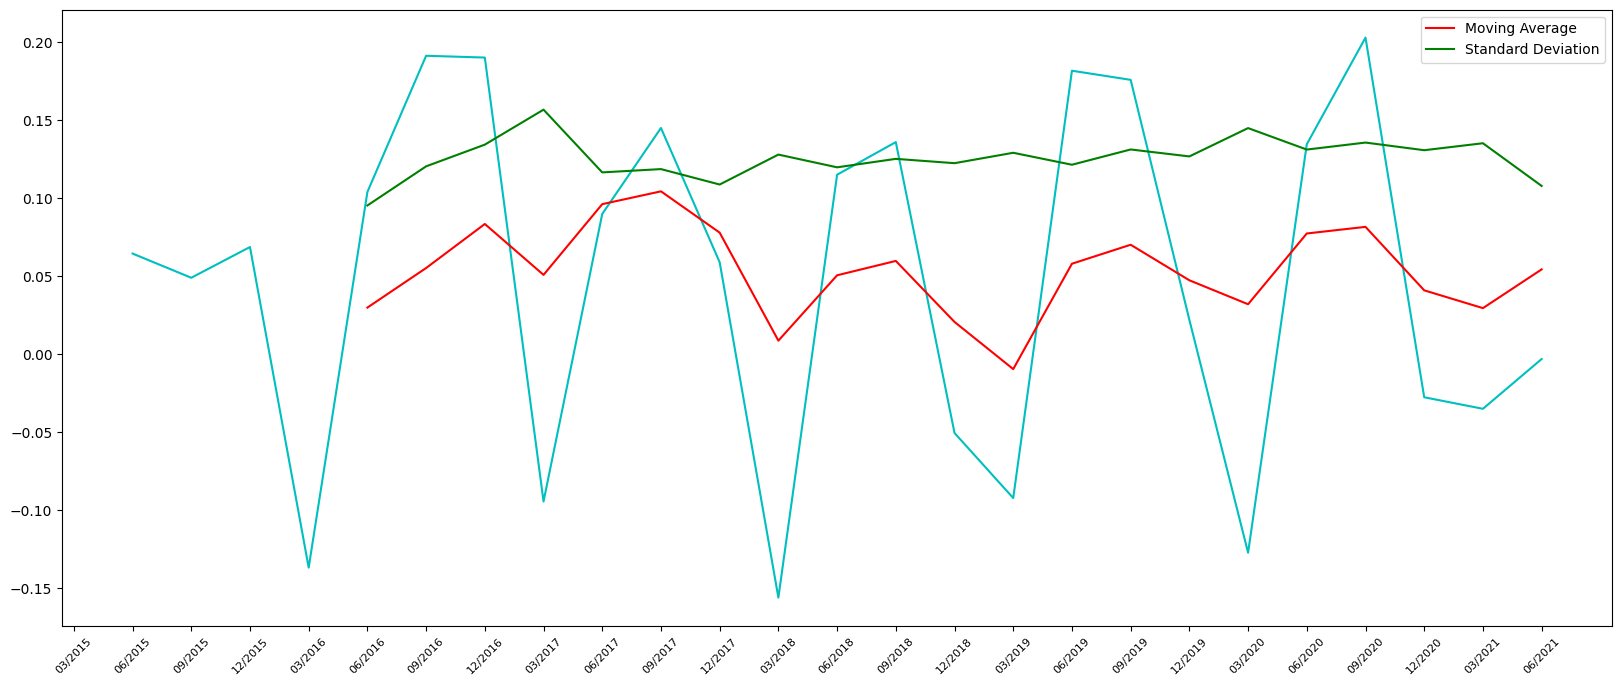

In [12]:
# Use log to stabalize the variance
df_log = np.log(df_train)

# Plot the data
plt.figure(figsize=(20,8))
plt.xticks(fontsize=8, rotation=45)
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=5).mean()
MStd_shift = df_shift.rolling(window=5).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

The moving average (red) and standard deviation (green) lines exhibit insignificant fluctuation over time. Now, we can retest using adfuller function

In [13]:
df_shift = df_shift.dropna()
print(adfuller(df_shift)[1])

0.01257757603805403


Since **p-value** of **0.01** is lower than significance level of **0.05**, we can reject the null hypothesis and conclude that the series is stationary

#Finding model terms for ARIMA model:
Here, we would find the best values for p, d, and q to put into the ARIMA model. The combinations that give the best aic results will be tried and compared using RMSE values. The model with the lowest RMSE will be chosen

The first model to be tested has d equal 0

In [14]:
order_aic=[]

# Go over all possible combinations of p and q
for p in range(6):
    for q in range(6):
        model=ARIMA(df_shift, order=(p,0,q)) # Assume d = 0
        results=model.fit()

        order_aic.append((p,q,results.aic))

order_df = pd.DataFrame(order_aic,columns=['p','q','AIC'])

# Sort AIC values from lowest to highest
print(order_df.sort_values('AIC'))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be use

    p  q        AIC
31  5  1 -54.756987
32  5  2 -54.451408
15  2  3 -51.859714
30  5  0 -51.823099
17  2  5 -50.673876
24  4  0 -50.201641
19  3  1 -49.952194
16  2  4 -49.877226
25  4  1 -49.865499
21  3  3 -49.803130
20  3  2 -49.803098
27  4  3 -49.628343
33  5  3 -49.473180
26  4  2 -49.298471
28  4  4 -48.827315
14  2  2 -48.705240
22  3  4 -48.135826
23  3  5 -47.694563
34  5  4 -47.439850
18  3  0 -47.248070
29  4  5 -46.792699
4   0  4 -46.741614
9   1  3 -46.318061
5   0  5 -45.637065
12  2  0 -45.593287
13  2  1 -45.485561
10  1  4 -45.400537
11  1  5 -44.275089
35  5  5 -43.551809
3   0  3 -42.152150
8   1  2 -41.415653
7   1  1 -39.683437
1   0  1 -39.642557
0   0  0 -35.159659
6   1  0 -33.218694
2   0  2 -14.777364


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
order_aic=[]

for p in range(6):
    for q in range(6):
        model=ARIMA(df_shift, order=(p,1,q)) # Assume d = 1
        results=model.fit()

        order_aic.append((p,q,results.aic))

order_df = pd.DataFrame(order_aic,columns=['p','q','AIC'])
print(order_df.sort_values('AIC'))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be use

    p  q          AIC
18  3  0   -45.638150
32  5  2   -44.944318
24  4  0   -44.269120
19  3  1   -44.259839
31  5  1   -43.916158
21  3  3   -43.560457
26  4  2   -42.604537
20  3  2   -42.361477
30  5  0   -42.314852
25  4  1   -42.281975
22  3  4   -42.199802
27  4  3   -41.928869
16  2  4   -41.839884
15  2  3   -41.577768
23  3  5   -40.288353
17  2  5   -40.280768
33  5  3   -40.259424
28  4  4   -40.182215
34  5  4   -38.312644
13  2  1   -38.186364
14  2  2   -37.468307
10  1  4   -36.405338
5   0  5   -36.288253
11  1  5   -35.299490
3   0  3   -34.184228
4   0  4   -31.950900
9   1  3   -29.530888
1   0  1   -29.394009
2   0  2   -27.471236
7   1  1   -27.396015
8   1  2   -26.370572
12  2  0   -26.208541
0   0  0   -16.931895
6   1  0   -15.977625
29  4  5  4073.805933
35  5  5  4075.806289


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

The model with d=0 produces lower AIC so we will stick to that model, using p=5, d=0, q=1 because its AIC value is lowest, at -54.76. The model has now become ARMA. Now, the next step is to fit the model using the above combination

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


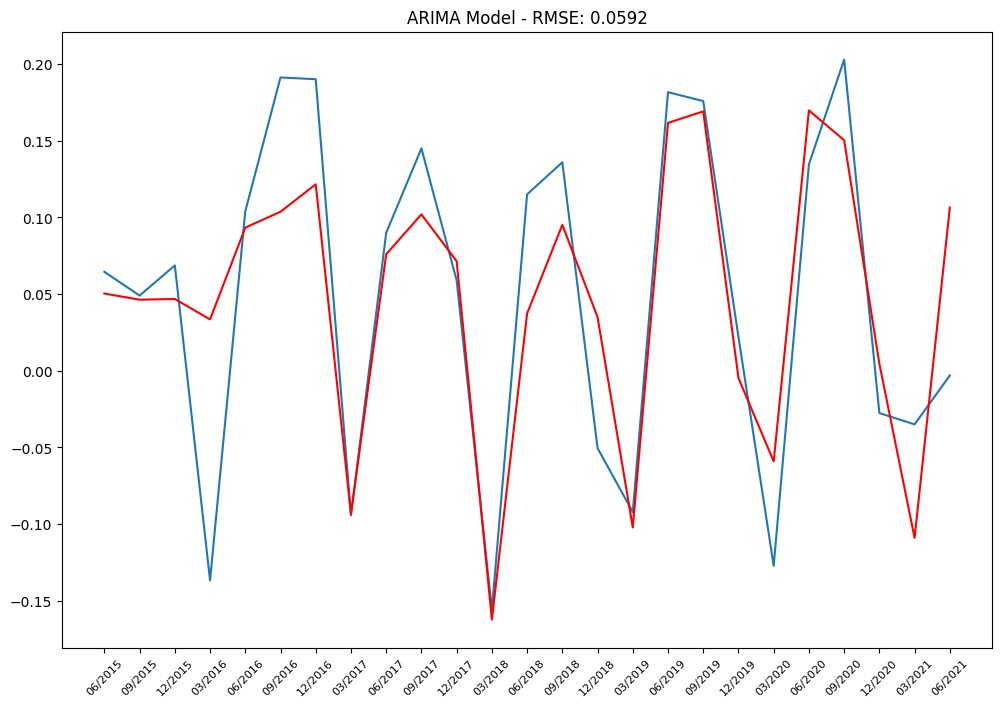

In [16]:
# Fit the model
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(12,8))
model_ARMA = ARIMA(df_shift, order=(5,0,1)) # Using p=5, d=0, q=1
results_ARMA = model_ARMA.fit()
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.xticks(fontsize=8, rotation=45)
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, df_shift, squared=False)) # Calculate RMSE value to measure its prediction error
plt.show()

An RMSE value of 0.0592 suggests that the model's predictive performance is relatively strong

In [17]:
results_ARMA.fittedvalues

06/2015    0.050303
09/2015    0.046283
12/2015    0.046758
03/2016    0.033424
06/2016    0.093273
09/2016    0.103645
12/2016    0.121515
03/2017   -0.093465
06/2017    0.075915
09/2017    0.101947
12/2017    0.071385
03/2018   -0.162304
06/2018    0.037272
09/2018    0.095112
12/2018    0.034926
03/2019   -0.102239
06/2019    0.161576
09/2019    0.169085
12/2019   -0.004785
03/2020   -0.059177
06/2020    0.169749
09/2020    0.150263
12/2020    0.004498
03/2021   -0.109030
06/2021    0.106344
dtype: float64

In [18]:
results_ARMA.aic

-54.75698707827438

# Inverse Transformation
Use inverse transformation to get back the original values. Compare the predicted training data with the original one

In [19]:
predictions = pd.Series(results_ARMA.fittedvalues)
predictions

06/2015    0.050303
09/2015    0.046283
12/2015    0.046758
03/2016    0.033424
06/2016    0.093273
09/2016    0.103645
12/2016    0.121515
03/2017   -0.093465
06/2017    0.075915
09/2017    0.101947
12/2017    0.071385
03/2018   -0.162304
06/2018    0.037272
09/2018    0.095112
12/2018    0.034926
03/2019   -0.102239
06/2019    0.161576
09/2019    0.169085
12/2019   -0.004785
03/2020   -0.059177
06/2020    0.169749
09/2020    0.150263
12/2020    0.004498
03/2021   -0.109030
06/2021    0.106344
dtype: float64

In [20]:
# Cumulative sum before exponential transformation
predictions_cumsum = predictions.cumsum()
predictions_cumsum

06/2015    0.050303
09/2015    0.096586
12/2015    0.143344
03/2016    0.176767
06/2016    0.270040
09/2016    0.373685
12/2016    0.495200
03/2017    0.401736
06/2017    0.477651
09/2017    0.579598
12/2017    0.650984
03/2018    0.488679
06/2018    0.525951
09/2018    0.621063
12/2018    0.655989
03/2019    0.553749
06/2019    0.715325
09/2019    0.884410
12/2019    0.879625
03/2020    0.820448
06/2020    0.990197
09/2020    1.140460
12/2020    1.144958
03/2021    1.035928
06/2021    1.142272
dtype: float64

In [21]:
# Add first value of log series to predictions_cumsum
predictions_log = pd.Series(df_log.iloc[0], index=df_log.index)

# Add prediction_cumsum to prediction_log with the same monthly index
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log.index = pd.to_datetime(predictions_log.index, format="%m/%Y")

# Sort by month
predictions_log = predictions_log.sort_index()
predictions_log.index = predictions_log.index.strftime("%m/%Y")
predictions_log

03/2015    15.087714
06/2015    15.138018
09/2015    15.184300
12/2015    15.231058
03/2016    15.264482
06/2016    15.357755
09/2016    15.461400
12/2016    15.582914
03/2017    15.489450
06/2017    15.565365
09/2017    15.667312
12/2017    15.738698
03/2018    15.576394
06/2018    15.613666
09/2018    15.708777
12/2018    15.743703
03/2019    15.641464
06/2019    15.803039
09/2019    15.972125
12/2019    15.967339
03/2020    15.908163
06/2020    16.077912
09/2020    16.228174
12/2020    16.232672
03/2021    16.123642
06/2021    16.229986
dtype: float64

In [22]:
# Apply exponential transformation
predictions_ARMA = np.exp(predictions_log)
predictions_ARMA

03/2015    3.568708e+06
06/2015    3.752818e+06
09/2015    3.930590e+06
12/2015    4.118740e+06
03/2016    4.258730e+06
06/2016    4.675070e+06
09/2016    5.185618e+06
12/2016    5.855631e+06
03/2017    5.333135e+06
06/2017    5.753764e+06
09/2017    6.371289e+06
12/2017    6.842733e+06
03/2018    5.817572e+06
06/2018    6.038496e+06
09/2018    6.641026e+06
12/2018    6.877068e+06
03/2019    6.208709e+06
06/2019    7.297476e+06
09/2019    8.641827e+06
12/2019    8.600573e+06
03/2020    8.106385e+06
06/2020    9.606126e+06
09/2020    1.116366e+07
12/2020    1.121399e+07
03/2021    1.005562e+07
06/2021    1.118391e+07
dtype: float64

Now, we can visualize and compare the predicted with the actual datasets

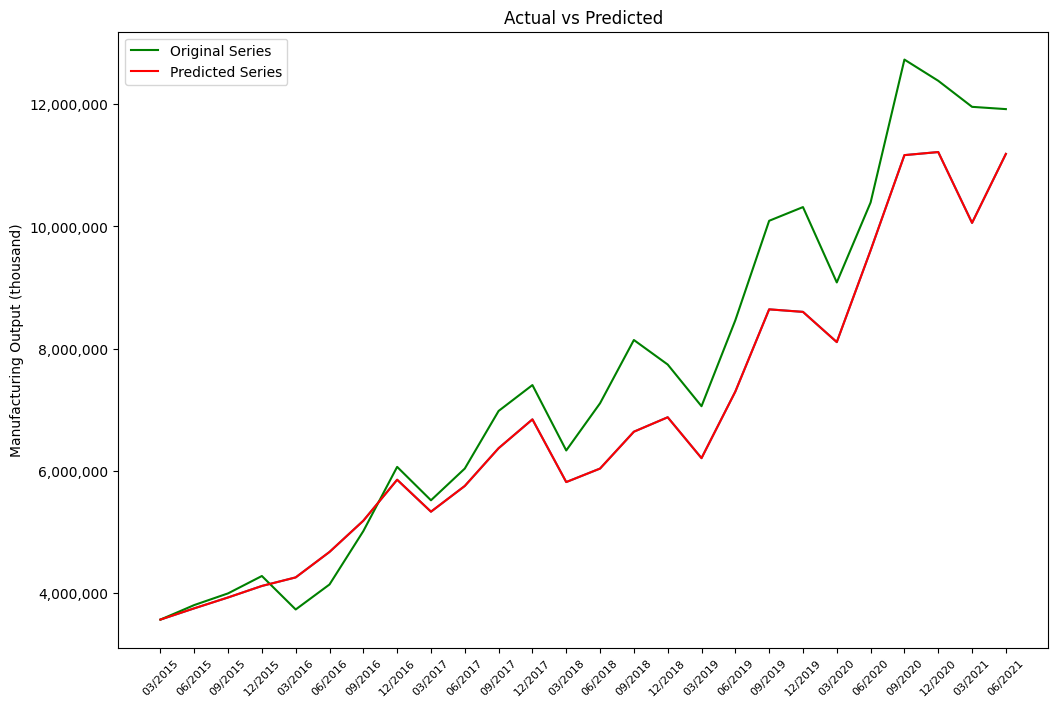

In [23]:
import matplotlib.dates as mdates
from datetime import datetime


# Plotting the original vs predicted series
ax = predictions_ARMA.plot(figsize=(12, 8), grid=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.plot(df_train, color = 'g', label = 'Original Series')
ax.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')
ax.set_ylabel('Manufacturing Output (thousand)')


x_labels = df_train.index.tolist()
x_ticks = range(len(x_labels))
plt.xticks(x_ticks, x_labels, fontsize=8, rotation=45)
plt.title('Actual vs Predicted')
plt.xticks(fontsize=8, rotation=45)
plt.legend()
plt.show()

# Forecasting the data for the next six quarters
Forecast future data with predictions_ARMA and compare it with test data

In [24]:
#Forecasting the values for next six quarters
forecasted_ARMA = results_ARMA.forecast(steps=6)
forecasted_ARMA.index = pd.to_datetime(forecasted_ARMA.index, format="%m/%Y")
forecasted_ARMA.index = forecasted_ARMA.index.strftime("%m/%Y")
forecasted_ARMA

09/2021    0.178437
12/2021   -0.006853
03/2022    0.010991
06/2022    0.042614
09/2022    0.188093
12/2022    0.006974
Name: predicted_mean, dtype: float64

In [25]:
#Creating a series of cumulative sum
forecasted_cumsum = forecasted_ARMA.cumsum()
forecasted_cumsum

09/2021    0.178437
12/2021    0.171584
03/2022    0.182575
06/2022    0.225189
09/2022    0.413282
12/2022    0.420256
Name: predicted_mean, dtype: float64

In [26]:
#Making a new dataframe to get the indices from 2020-2021
index = pd.date_range('2021-09-01','2022-12-01' , freq='3M')
df1 = pd.DataFrame()
df1['cumsum'] = forecasted_cumsum
df1

,cumsum
09/2021,0.178437
12/2021,0.171584
03/2022,0.182575
06/2022,0.225189
09/2022,0.413282
12/2022,0.420256


In [27]:
#Adding last value of the log of the training data
df1['Forecasted'] = df1['cumsum'] + float(df_log.loc['06/2021'])
df1

,cumsum,Forecasted
09/2021,0.178437,16.471838
12/2021,0.171584,16.464985
03/2022,0.182575,16.475976
06/2022,0.225189,16.518590
09/2022,0.413282,16.706683
12/2022,0.420256,16.713657


In [28]:
#Applying exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(df1['Forecasted'])

forecasted_ARMA

09/2021    1.424388e+07
12/2021    1.414661e+07
03/2022    1.430294e+07
06/2022    1.492562e+07
09/2022    1.801441e+07
12/2022    1.814049e+07
Name: Forecasted, dtype: float64

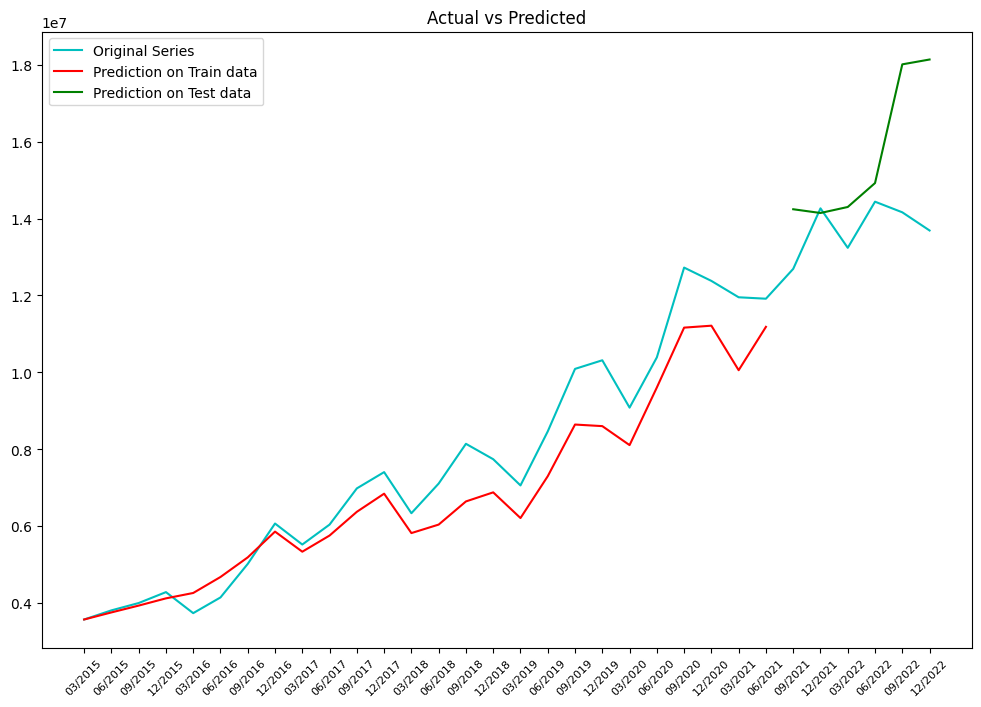

In [29]:
#Plotting the original vs predicted series
plt.figure(figsize=(12,8))
plt.plot(df_etron, color = 'c', label = 'Original Series')
plt.plot(predictions_ARMA, color = 'r', label = 'Prediction on Train data')
plt.plot(forecasted_ARMA, label = 'Prediction on Test data', color='g')
x_labels = df_etron.index.tolist()
x_ticks = range(len(x_labels))
plt.xticks(x_ticks, x_labels, fontsize=8, rotation=45)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()